In [1]:
import sys
sys.path.append("/home/raghav/multimodal-classification/UniS-MMC/")

import torch
import os 
import numpy as np
from PIL import Image, ImageOps
import torchvision.transforms as transforms
# import wandb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from src.metrics import *
from PIL import Image
sys.path.append('..')  
import scipy

from types import SimpleNamespace
from src.config import Config

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [3]:
args = SimpleNamespace(
    name='MMC',
    dataset='n24news',  # Adjust as per your dataset or requirement
    text_type='abstract',
    mmc='UniSMMC',
    mmc_tao=0.07,
    batch_size=1000,
    lr_mm=0.001,
    min_epoch=1,
    valid_step=50,
    max_length=512,
    text_encoder='roberta_base',
    image_encoder='vit_base',
    text_out=768,
    img_out=768,
    lr_mm_cls=0.001,
    mm_dropout=0.0,
    lr_text_tfm=2e-5,
    lr_img_tfm=5e-5,
    lr_img_cls=0.0001,
    lr_text_cls=5e-5,
    text_dropout=0.0,
    img_dropout=0.1,
    nplot='',
    data_dir='../datasets/',  # Ensure this path is correct in your notebook environment
    test_only=False,
    pretrained_dir='../pretrained_models',  # Adjust as necessary
    model_save_dir='Path/To/results/models',
    res_save_dir='Path/To/results/results',
    fig_save_dir='Path/To/results/imgs',
    logs_dir='Path/To/results/logs',
    local_rank=-1,
    seeds=None,
    model_path='./Path/To/results/models',
    save_model=True,
    cross_attention=False,
    text_mixup=False,
    image_mixup=False,
    image_embedding_mixup=False,
    alpha=0.2,
    multi_mixup=True,
    mixup_pct=0.33,
    lambda_mixup=0.1,
    mixup_beta=0.15,
    mixup_s_thresh=0.5,
    lr_scheduler='ReduceLROnPlateau',
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

config = Config(args)
args = config.get_config()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.local_rank == -1:
    device = torch.device("cuda")
else:
    torch.cuda.set_device(args.local_rank)
    device = torch.device("cuda", args.local_rank)
    torch.distributed.init_process_group(backend="nccl")

args.device = device
print(args.data_dir)
args.data_dir = os.path.join(args.data_dir, args.dataset)

#args.best_model_save_path = os.path.join(args.model_save_dir, f'{args.dataset}-best-{time.strftime("%Y%m%d-%H%M%S")}.pth')v

../datasets/


In [4]:
print(args.device)

cuda


In [5]:
from model.utils import *
from model.model_noise_random import MMC
from data.dataloader import MMDataLoader

/home/raghav/multimodal-classification/UniS-MMC/.venv_mm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_loader, valid_loader, test_loader = MMDataLoader(args)

../datasets/n24news/news/nytimes_train.json


../datasets/n24news/news/nytimes_dev.json
../datasets/n24news/news/nytimes_test.json


In [7]:
model = MMC(args).to(args.device)

In [14]:
#model_path= '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-m3co+multisoftclip.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-m3co.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-multisoftclip.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-no-unimodal.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/Food101-best-mixup.pth'


model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-m3co+multisoftclip-abstract.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-m3co-abstract.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-multisoftclip-abstract.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-no-unimodal-abstract.pth'
#model_path = '/home/raghav/multimodal-classification/UniS-MMC/saved-models-for-visualization/n24news-best-mixup-abstract.pth'
model.load_state_dict(torch.load(model_path), strict=False)
model = model.to(device=args.device)

In [15]:
dataloader = test_loader

In [16]:
n24news_img_mean = -0.2
n24news_img_std = 0.6

n24news_text_mean = 0.039
n24news_text_std = 0.74

In [17]:
model.eval()
with torch.no_grad():
        y_pred = []
        y_true = []

        with tqdm(dataloader) as td:
            for batch_image, text_input_ids, text_token_type_ids, text_attention_mask, batch_label in td:
                text = text_input_ids.cuda(), text_token_type_ids.cuda(), text_attention_mask.cuda()
                image = batch_image.cuda()
                logit = model.infer(text, image, noise_text=False, noise_image=False, random_text=True, random_image=True)
                y_pred.append(logit.cpu())
                y_true.append(batch_label.cpu())
            
        logits = torch.cat(y_pred)
        true = torch.cat(y_true).data.cpu().numpy()
        prob = F.softmax(logits, dim=1).data.cpu().numpy()

100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


In [18]:
best_results = collect_metrics(args.dataset, true, prob)
acc = best_results['acc']
print(acc)

0.0495


<built-in method mean of numpy.ndarray object at 0x7f1dde824e70>


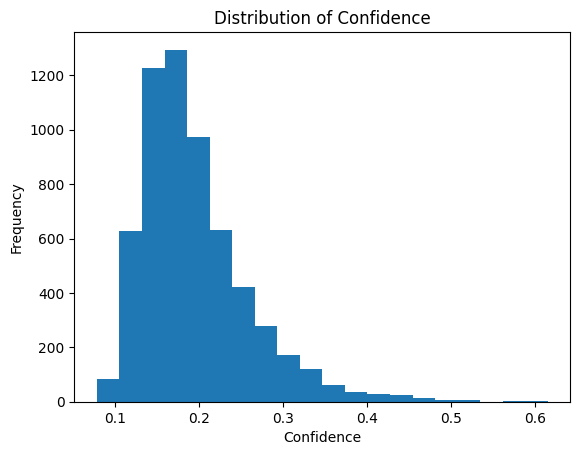

In [13]:
softmax_logits = F.softmax(logits, dim=1)
max_values, _ = torch.max(softmax_logits, dim=1)

print(max_values.cpu().numpy().mean)
plt.hist(max_values, bins=20)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence')
plt.show()

<built-in method mean of numpy.ndarray object at 0x7f1ea8be1f30>


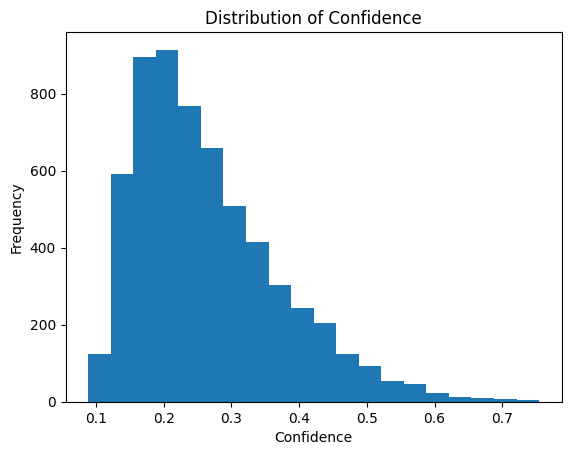

In [21]:
softmax_logits = F.softmax(logits, dim=1)
max_values_2, _ = torch.max(softmax_logits, dim=1)

print(max_values_2.cpu().numpy().mean)

plt.hist(max_values_2, bins=20)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence')
plt.show()

In [37]:
import numpy as np

np.save('m3co_multisoftclip.npy', max_values.cpu().numpy())
np.save('multisoftclip.npy', max_values_2.cpu().numpy())

In [23]:
print(torch.mean(max_values))
print(torch.mean(max_values_2))

tensor(0.1948)
tensor(0.2652)


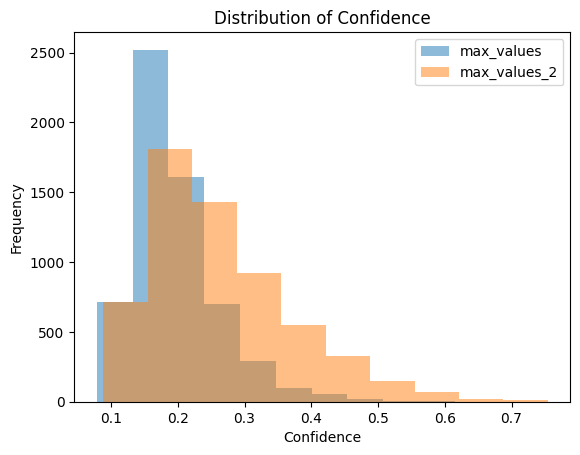

In [28]:
plt.hist(max_values, bins=10, alpha=0.5, label='max_values')
plt.hist(max_values_2, bins=10, alpha=0.5, label='max_values_2')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence')
plt.legend()

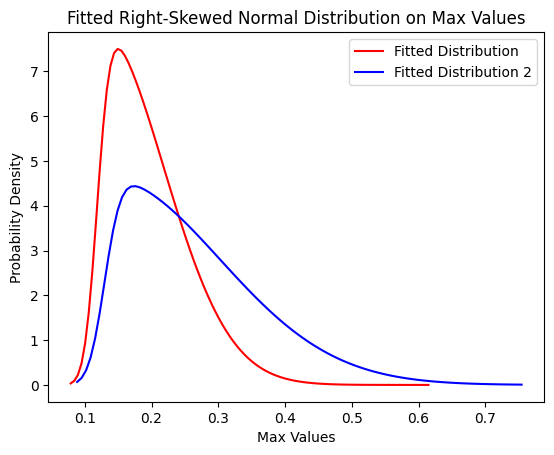

In [30]:
import scipy.stats as stats

# Fit a right-skewed normal distribution on max_values
shape, loc, scale = stats.skewnorm.fit(max_values)
shape_2, loc_2, scale_2 = stats.skewnorm.fit(max_values_2)

# Generate the x values for the fitted distribution
x_1 = np.linspace(min(max_values), max(max_values), 100)
x_2 = np.linspace(min(max_values_2), max(max_values_2), 100)

# Calculate the probability density function (PDF) of the fitted distribution
pdf_1 = stats.skewnorm.pdf(x_1, shape, loc, scale)
pdf_2 = stats.skewnorm.pdf(x_2, shape_2, loc_2, scale_2)

# Plot the fitted distribution
plt.plot(x_1, pdf_1, 'r-', label='Fitted Distribution')
plt.plot(x_2, pdf_2, 'b-', label='Fitted Distribution 2')

plt.xlabel('Max Values')
plt.ylabel('Probability Density')
plt.title('Fitted Right-Skewed Normal Distribution on Max Values')
plt.legend()
plt.show()

In [2]:
max_values = np.load('m3co_multisoftclip.npy')
max_values_2 = np.load('multisoftclip.npy')

/tmp/ipykernel_3248840/351965870.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


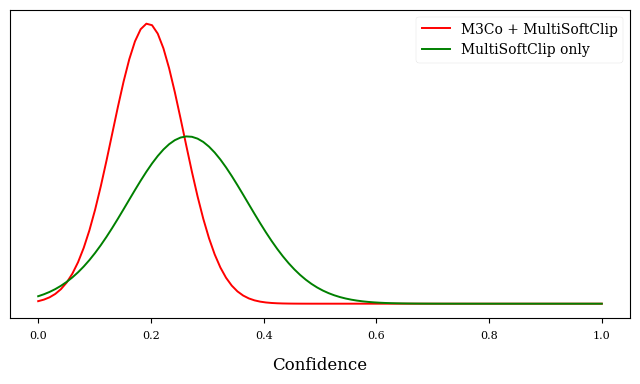

In [7]:
plt.style.use('seaborn-paper')
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(8, 4))

# Configure axis padding and title sizes
plt.rcParams['axes.labelpad'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titlepad'] = 15

mu, sigma = scipy.stats.norm.fit(max_values)
mu_2, sigma_2 = scipy.stats.norm.fit(max_values_2)

x = np.linspace(0, 1, 100)
y = scipy.stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, 'r-', label='Gaussian fit (max_values)')

y_2 = scipy.stats.norm.pdf(x, mu_2, sigma_2)
plt.plot(x, y_2, 'g-', label='Gaussian fit (max_values_2)')

# Customize legend
plt.legend(['M3Co + MultiSoftClip', 'MultiSoftClip only'], fontsize=10, title_fontsize=14, frameon=True)

plt.xlabel('Confidence', fontsize=12)

# Remove y ticks
plt.yticks([])

plt.show()
